In [21]:
import numpy as np
import random
from collections import defaultdict
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

###############################################################################
#                      VARIABLES FOR EXPERIMENTATION
###############################################################################
# --- ENVIRONMENT SETTINGS ---
ENV_SIZE = (10, 10, 10) 
OBSTACLES_COUNT = 15 
MINES_COUNT = 5 
SLIP_P = 0.2
SLIP_MODE = "random"
PORTAL_EXIT = (0,0,0)
MOVING_OBSTACLES = True
STEP_PENALTY = -0.01
MINE_PENALTY = -10.0
START_STATE = (0,0,0)
GOAL_STATE  = (9,9,9)       
GAMMA = 0.9                 
THETA = 1e-3             
MAX_ITERS_VALUE_ITER = 60   
SAMPLES_VALUE_ITER = 20    

# Monte Carlo
MC_EPISODES = 4000         
MC_EPSILON  = 0.15      

# Q-Learning
QL_EPISODES   = 4000        
QL_ALPHA      = 0.1    
QL_EPSILON    = 0.15  
###############################################################################


In [ ]:

###############################################################################
#                          3D GRID ENVIRONMENT
###############################################################################
class Fancy3DGridEnv:
    """
    Fancy3DGridEnv 
    --------------
    3D environment with:
      - random/fixed obstacles,
      - random mines,
      - slip probability for portal teleports,
      - moving obstacles,
      - step penalties,
      - negative reward for mines,
      - single (start) -> single (goal).

    PRIMARY VARIABLES IN-USE:
      - x_size, y_size, z_size (ENV_SIZE)
      - obstacles_count, mines_count (or direct sets)
      - slip_p, slip_mode, portal_exit
      - moving_obstacles
      - step_penalty, mine_penalty
    """

    def __init__(
        self,
        x_size=10,
        y_size=10,
        z_size=10,
        start_state=(0,0,0),
        goal_state=(9,9,9),
        obstacles=None,
        mines=None,
        slip_p=0.2,
        slip_mode='random',
        portal_exit=(0,0,0),
        moving_obstacles=True,
        step_penalty=-0.01,
        mine_penalty=-10.0,
        obstacles_count=10,
        mines_count=5
    ):
        self.x_size = x_size
        self.y_size = y_size
        self.z_size = z_size
        
        self.start_state = start_state
        self.goal_state  = goal_state
        
        # If no obstacles specified, randomly create obstacles_count of them
        if obstacles is None:
            obstacles = self._generate_random_obstacles(obstacles_count)
        self.obstacles = set(obstacles)
        
        # If no mines specified, create mines_count randomly
        if mines is None:
            mines = self._generate_random_mines(mines_count)
        self.mines = set(mines)
        
        self.slip_p      = slip_p
        self.slip_mode   = slip_mode
        self.portal_exit = portal_exit
        
        self.moving_obstacles = moving_obstacles
        self.step_penalty  = step_penalty
        self.mine_penalty  = mine_penalty
        
        # 6 possible actions in 3D
        # 0: x+1, 1: x-1, 2: y+1, 3: y-1, 4: z+1, 5: z-1
        self.actions = [0,1,2,3,4,5]
        
        self.time_step = 0  # for obstacle shifting

    def _generate_random_obstacles(self, count=10):
        """Generate 'count' random obstacle positions (excluding start/goal)."""
        obs = set()
        possible_cells = []
        for x in range(self.x_size):
            for y in range(self.y_size):
                for z in range(self.z_size):
                    if (x,y,z) not in [self.start_state, self.goal_state]:
                        possible_cells.append((x,y,z))
        random.shuffle(possible_cells)
        return set(possible_cells[:count])

    def _generate_random_mines(self, count=5):
        """Generate 'count' random mines (excluding start, goal, obstacles)."""
        mines = set()
        possible_cells = []
        for x in range(self.x_size):
            for y in range(self.y_size):
                for z in range(self.z_size):
                    if ((x,y,z) != self.start_state and
                        (x,y,z) != self.goal_state and
                        (x,y,z) not in self.obstacles):
                        possible_cells.append((x,y,z))
        random.shuffle(possible_cells)
        return set(possible_cells[:count])
    
    def reset(self):
        """Reset environment to start_state, time=0."""
        self.time_step = 0
        return self.start_state

    def step(self, state, action):
        """
        step(...)
        1) Move in 3D
        2) Bound/Obstacle check
        3) Slip check
        4) Mines or goal => rewards
        5) Possibly shift obstacles
        returns next_state, reward, done
        """
        (x, y, z) = state
        # Movement logic
        if action == 0:
            nx, ny, nz = x+1, y, z
        elif action == 1:
            nx, ny, nz = x-1, y, z
        elif action == 2:
            nx, ny, nz = x, y+1, z
        elif action == 3:
            nx, ny, nz = x, y-1, z
        elif action == 4:
            nx, ny, nz = x, y, z+1
        elif action == 5:
            nx, ny, nz = x, y, z-1
        else:
            nx, ny, nz = x, y, z

        # Bound check
        if not self._in_bounds(nx, ny, nz):
            nx, ny, nz = x, y, z
        # Obstacle check
        if (nx, ny, nz) in self.obstacles:
            nx, ny, nz = x, y, z
        
        next_state = (nx, ny, nz)
        
        # Slip / portal
        if random.random() < self.slip_p:
            if self.slip_mode == 'random':
                free_cells = []
                for xx in range(self.x_size):
                    for yy in range(self.y_size):
                        for zz in range(self.z_size):
                            if (xx,yy,zz) not in self.obstacles:
                                free_cells.append((xx,yy,zz))
                if free_cells:
                    next_state = random.choice(free_cells)
            else:  # 'fixed'
                next_state = self.portal_exit
        
        # Reward setup
        reward = self.step_penalty
        done   = False
        # Mine check
        if next_state in self.mines:
            reward += self.mine_penalty
            done = True
        # Goal check
        elif next_state == self.goal_state:
            reward += 1.0
            done = True
        
        # Move obstacles over time
        self.time_step += 1
        if self.moving_obstacles:
            self._update_obstacles()
        
        return next_state, reward, done

    def _in_bounds(self, x, y, z):
        return (0 <= x < self.x_size) and (0 <= y < self.y_size) and (0 <= z < self.z_size)

    def _update_obstacles(self):
        """
        Shift obstacles in +z each step (wrap around).
        """
        new_obs = set()
        for (ox, oy, oz) in self.obstacles:
            newz = oz + 1
            if newz >= self.z_size:
                newz = 0
            new_obs.add((ox, oy, newz))
        self.obstacles = new_obs


In [ ]:

###############################################################################
#                          HELPER FOR VALUE ITERATION
###############################################################################
def simulate_step_once(env, s, a):
    (x,y,z) = s
    if a == 0:
        nx, ny, nz = x+1, y, z
    elif a == 1:
        nx, ny, nz = x-1, y, z
    elif a == 2:
        nx, ny, nz = x, y+1, z
    elif a == 3:
        nx, ny, nz = x, y-1, z
    elif a == 4:
        nx, ny, nz = x, y, z+1
    elif a == 5:
        nx, ny, nz = x, y, z-1
    else:
        nx, ny, nz = x,y,z

    if not env._in_bounds(nx, ny, nz):
        nx, ny, nz = x, y, z

    if (nx, ny, nz) in env.obstacles:
        nx, ny, nz = x, y, z

    final_state = (nx, ny, nz)
    # slip check
    if random.random() < env.slip_p:
        if env.slip_mode == 'random':
            free_cells = []
            for xx in range(env.x_size):
                for yy in range(env.y_size):
                    for zz in range(env.z_size):
                        if (xx,yy,zz) not in env.obstacles:
                            free_cells.append((xx,yy,zz))
            if free_cells:
                final_state = random.choice(free_cells)
        else:
            final_state = env.portal_exit

    reward = env.step_penalty
    done = False
    if final_state in env.mines:
        reward += env.mine_penalty
        done = True
    elif final_state == env.goal_state:
        reward += 1.0
        done = True
    return final_state, reward, done



In [ ]:
###############################################################################
#                            VALUE ITERATION 3D WITH TRACE
###############################################################################
def value_iteration_3d_trace(env, gamma=GAMMA, theta=THETA, max_iters=MAX_ITERS_VALUE_ITER, samples=SAMPLES_VALUE_ITER):
    states = []
    for x in range(env.x_size):
        for y in range(env.y_size):
            for z in range(env.z_size):
                states.append((x,y,z))
   
    V = {s: 0.0 for s in states}
    delta_trace = []  
    for iteration in range(max_iters):
        delta = 0.0
        for s in states:
            if s in env.obstacles or s in env.mines or s == env.goal_state:
                continue
            best_val = float('-inf')
            for a in env.actions:
                val_sum = 0.0
                for _ in range(samples):
                    ns, r, done = simulate_step_once(env, s, a)
                    val_sum += r + (gamma * V[ns] if not done else 0.0)
                avg_val = val_sum / samples
                if avg_val > best_val:
                    best_val = avg_val
            old_v = V[s]
            V[s] = best_val
            delta = max(delta, abs(best_val - old_v))
        delta_trace.append(delta)
        if delta < theta:
            print(f"[ValueIteration3D] Converged at iteration {iteration} with delta {delta:.5f}")
            break
    policy = {}
    for s in states:
        if s in env.obstacles or s in env.mines or s == env.goal_state:
            policy[s] = None
            continue
        best_a = None
        best_val = float('-inf')
        for a in env.actions:
            val_sum = 0.0
            for _ in range(samples):
                ns, r, done = simulate_step_once(env, s, a)
                val_sum += r + (gamma * V[ns] if not done else 0.0)
            avg_val = val_sum / samples
            if avg_val > best_val:
                best_val = avg_val
                best_a = a
        policy[s] = best_a
    return V, policy, delta_trace

In [36]:
###############################################################################
#                            MONTE CARLO (ON-POLICY) WITH TRACE
###############################################################################
def mc_control_3d_trace(env, gamma=GAMMA, epsilon=MC_EPSILON, episodes=MC_EPISODES):
    Q = defaultdict(lambda: np.zeros(len(env.actions)))
    returns_sum = defaultdict(lambda: np.zeros(len(env.actions)))
    returns_count = defaultdict(lambda: np.zeros(len(env.actions)))
    episode_rewards = []  

    def epsilon_greedy(s):
        if s in env.obstacles or s in env.mines or s == env.goal_state:
            return 0
        if random.random() < epsilon:
            return random.choice(env.actions)
        else:
            return np.argmax(Q[s])
   
    for ep in range(episodes):
        episode = []
        s = env.reset()
        done = False
        total_reward = 0.0
        while not done:
            a = epsilon_greedy(s)
            ns, r, done = env.step(s, a)
            episode.append((s, a, r))
            total_reward += r
            s = ns
       
        episode_rewards.append(total_reward)
       
        G = 0.0
        visited = set()
        for t in reversed(range(len(episode))):
            s_t, a_t, r_t = episode[t]
            G = gamma * G + r_t
            if (s_t, a_t) not in visited:
                visited.add((s_t, a_t))
                returns_sum[s_t][a_t] += G
                returns_count[s_t][a_t] += 1
                Q[s_t][a_t] = returns_sum[s_t][a_t] / returns_count[s_t][a_t]
   
    policy = {}
    for x in range(env.x_size):
        for y in range(env.y_size):
            for z in range(env.z_size):
                s = (x, y, z)
                if s in env.obstacles or s in env.mines or s == env.goal_state:
                    policy[s] = None
                else:
                    policy[s] = np.argmax(Q[s])
    return Q, policy, episode_rewards


In [37]:
###############################################################################
#                            Q-LEARNING (TD) WITH TRACE
###############################################################################
def q_learning_3d_trace(env, alpha=QL_ALPHA, gamma=GAMMA, epsilon=QL_EPSILON, episodes=QL_EPISODES):
    Q = defaultdict(lambda: np.zeros(len(env.actions)))
    episode_rewards = []  

    def epsilon_greedy(s):
        if s in env.obstacles or s in env.mines or s == env.goal_state:
            return 0
        if random.random() < epsilon:
            return random.choice(env.actions)
        else:
            return np.argmax(Q[s])
   
    for ep in range(episodes):
        s = env.reset()
        done = False
        total_reward = 0.0
        while not done:
            a = epsilon_greedy(s)
            ns, r, done = env.step(s, a)
            total_reward += r
            if ns not in env.obstacles and ns not in env.mines and ns != env.goal_state:
                best_next_a = np.argmax(Q[ns])
            else:
                best_next_a = 0
            Q[s][a] += alpha * (r + gamma * Q[ns][best_next_a] - Q[s][a])
            s = ns
        episode_rewards.append(total_reward)
   
    policy = {}
    for x in range(env.x_size):
        for y in range(env.y_size):
            for z in range(env.z_size):
                s = (x, y, z)
                if s in env.obstacles or s in env.mines or s == env.goal_state:
                    policy[s] = None
                else:
                    policy[s] = np.argmax(Q[s])
    return Q, policy, episode_rewards



In [ ]:
###############################################################################
#                               MAIN SIMULATION
###############################################################################
if __name__ == "__main__":
    x_sz, y_sz, z_sz = ENV_SIZE
    env_3d = Fancy3DGridEnv(
        x_size=x_sz,
        y_size=y_sz,
        z_size=z_sz,
        start_state=START_STATE,
        goal_state=GOAL_STATE,
        obstacles=None,   # random obstacles_count
        mines=None,       # random mines_count
        slip_p=SLIP_P,
        slip_mode=SLIP_MODE,
        portal_exit=PORTAL_EXIT,
        moving_obstacles=MOVING_OBSTACLES,
        step_penalty=STEP_PENALTY,
        mine_penalty=MINE_PENALTY,
        obstacles_count=OBSTACLES_COUNT,
        mines_count=MINES_COUNT
    )

    # Print out the environment settings
    print("\n--- Running final 3D project code with the following parameters ---")
    print(f"ENV_SIZE={ENV_SIZE}, Start={START_STATE}, Goal={GOAL_STATE}")
    print(f"OBSTACLES_COUNT={OBSTACLES_COUNT}, MINES_COUNT={MINES_COUNT}")
    print(f"SLIP_P={SLIP_P}, SLIP_MODE={SLIP_MODE}")
    print(f"MOVING_OBSTACLES={MOVING_OBSTACLES}, STEP_PENALTY={STEP_PENALTY}, MINE_PENALTY={MINE_PENALTY}")
    print(f"Value Iteration => max_iters={MAX_ITERS_VALUE_ITER}, samples={SAMPLES_VALUE_ITER}")
    print(f"MonteCarlo => episodes={MC_EPISODES}, epsilon={MC_EPSILON}")
    print(f"Q-Learning => episodes={QL_EPISODES}, alpha={QL_ALPHA}, epsilon={QL_EPSILON}")
    print("-----------------------------------------------------------------\n")

    # 1) Value Iteration
    print("=== Value Iteration (Approx) ===")
    V_3d, pi_3d = value_iteration_3d(
        env_3d,
        gamma=GAMMA,
        theta=THETA,
        max_iters=MAX_ITERS_VALUE_ITER,
        samples=SAMPLES_VALUE_ITER
    )
    # Sample states
    sample_check = [START_STATE, (1,1,1), GOAL_STATE]
    for st in sample_check:
        print(f"State {st}: Value={round(V_3d[st],3)}, Policy={pi_3d[st]}")

    # 2) Monte Carlo
    print("\n=== Monte Carlo (On-Policy) ===")
    Q_mc, pi_mc = mc_control_3d(env_3d, gamma=GAMMA, epsilon=MC_EPSILON, episodes=MC_EPISODES)
    print(f"Sample policy at start state {START_STATE} => {pi_mc.get(START_STATE)}")

    # 3) Q-Learning
    print("\n=== Q-Learning ===")
    Q_q, pi_q = q_learning_3d(env_3d, alpha=QL_ALPHA, gamma=GAMMA, epsilon=QL_EPSILON, episodes=QL_EPISODES)
    print(f"Sample policy at start state {START_STATE} => {pi_q.get(START_STATE)}")

    print("\nFinished")



--- Running final 3D project code with the following parameters ---
ENV_SIZE=(10, 10, 10), Start=(0, 0, 0), Goal=(9, 9, 9)
OBSTACLES_COUNT=15, MINES_COUNT=5
SLIP_P=0.2, SLIP_MODE=random
MOVING_OBSTACLES=True, STEP_PENALTY=-0.01, MINE_PENALTY=-10.0
Value Iteration => max_iters=60, samples=20
MonteCarlo => episodes=4000, epsilon=0.15
Q-Learning => episodes=4000, alpha=0.1, epsilon=0.15
-----------------------------------------------------------------

=== Value Iteration (Approx) ===


State (0, 0, 0): Value=0.092, Policy=4
State (1, 1, 1): Value=0.119, Policy=2
State (9, 9, 9): Value=0.0, Policy=None

=== Monte Carlo (On-Policy) ===
Sample policy at start state (0, 0, 0) => 2

=== Q-Learning ===
Sample policy at start state (0, 0, 0) => 5

DONE. You can now analyze the final code and experiment with the top-level variables.


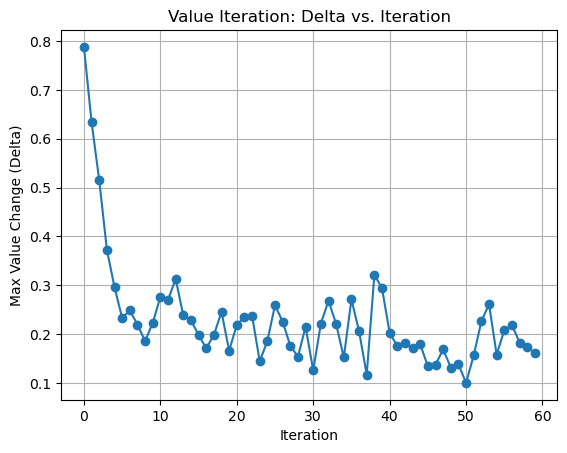

In [ ]:
V_3d, pi_3d, delta_trace = value_iteration_3d_trace(
    env_3d,
    gamma=GAMMA,
    theta=THETA,
    max_iters=MAX_ITERS_VALUE_ITER,
    samples=SAMPLES_VALUE_ITER
)
plt.figure()
plt.plot(delta_trace, marker='o')
plt.title("Value Iteration: Delta vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Max Value Change (Delta)")
plt.grid(True)
plt.show()


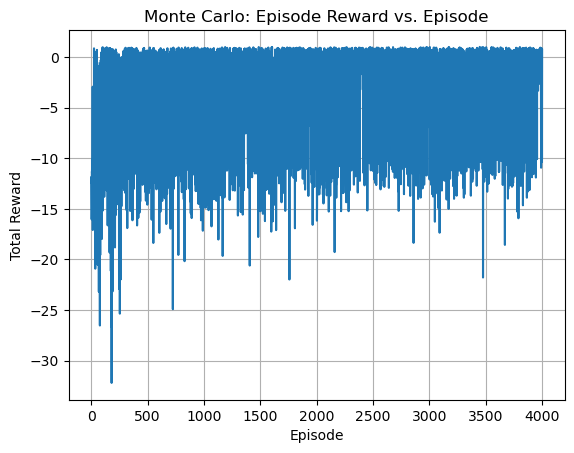

In [39]:
Q_mc, pi_mc, mc_rewards = mc_control_3d_trace(
    env_3d,
    gamma=GAMMA,
    epsilon=MC_EPSILON,
    episodes=MC_EPISODES
)

plt.figure()
plt.plot(mc_rewards)
plt.title("Monte Carlo: Episode Reward vs. Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


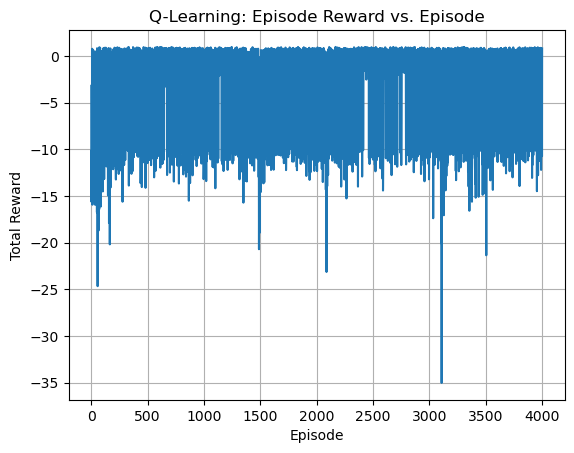

In [40]:
Q_q, pi_q, ql_rewards = q_learning_3d_trace(
    env_3d,
    alpha=QL_ALPHA,
    gamma=GAMMA,
    epsilon=QL_EPSILON,
    episodes=QL_EPISODES
)

plt.figure()
plt.plot(ql_rewards)
plt.title("Q-Learning: Episode Reward vs. Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


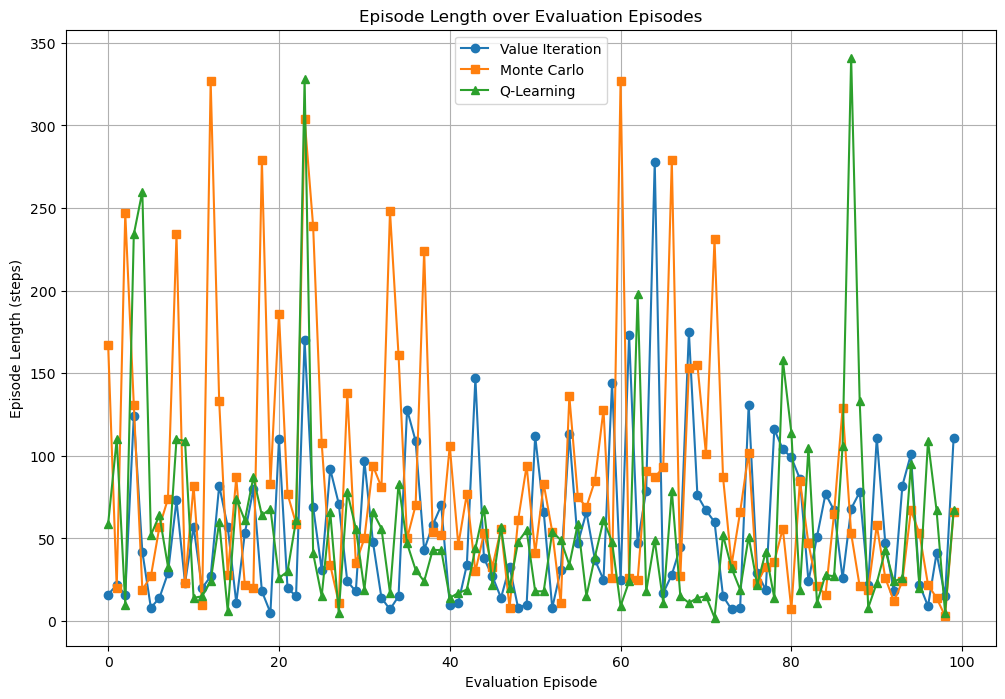

In [46]:
num_eval_episodes = 100
def run_episode_length(env, policy, max_steps=1000):
    s = env.reset()
    steps = 0
    while steps < max_steps:
        a = policy[s]
        if a is None:
            break
        s, r, done = env.step(s, a)
        steps += 1
        if done:
            break
    return steps

vi_lengths = []
for _ in range(num_eval_episodes):
    vi_lengths.append(run_episode_length(env_3d, pi_3d))
mc_lengths = []
for _ in range(num_eval_episodes):
    mc_lengths.append(run_episode_length(env_3d, pi_mc))
ql_lengths = []
for _ in range(num_eval_episodes):
    ql_lengths.append(run_episode_length(env_3d, pi_q))

plt.figure(figsize=(12, 8))
plt.plot(range(num_eval_episodes), vi_lengths, label='Value Iteration', marker='o')
plt.plot(range(num_eval_episodes), mc_lengths, label='Monte Carlo', marker='s')
plt.plot(range(num_eval_episodes), ql_lengths, label='Q-Learning', marker='^')
plt.xlabel("Evaluation Episode")
plt.ylabel("Episode Length (steps)")
plt.title("Episode Length over Evaluation Episodes")
plt.legend()
plt.grid(True)
plt.show()


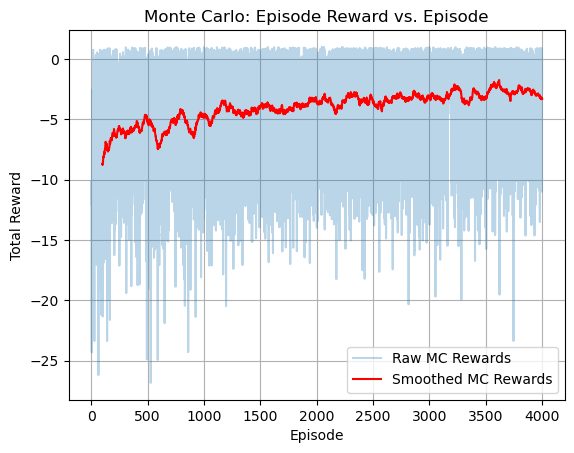

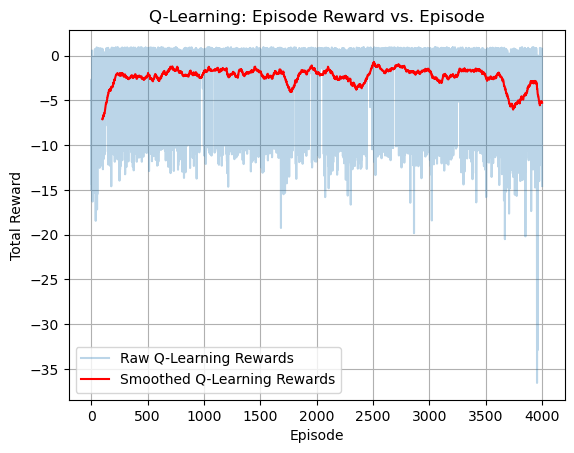

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_rewards(rewards, window=50):
    box = np.ones(window) / window
    return np.convolve(rewards, box, mode='valid')
Q_mc, pi_mc, mc_rewards = mc_control_3d_trace(
    env_3d,
    gamma=GAMMA,
    epsilon=MC_EPSILON,
    episodes=MC_EPISODES
)

window_size = 100
smoothed_mc = smooth_rewards(mc_rewards, window=window_size)

plt.figure()
plt.plot(mc_rewards, alpha=0.3, label='Raw MC Rewards')
plt.plot(range(window_size - 1, len(mc_rewards)),  # shift x-axis to align
         smoothed_mc, color='red', label='Smoothed MC Rewards')
plt.title("Monte Carlo: Episode Reward vs. Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()
Q_q, pi_q, ql_rewards = q_learning_3d_trace(
    env_3d,
    alpha=QL_ALPHA,
    gamma=GAMMA,
    epsilon=QL_EPSILON,
    episodes=QL_EPISODES
)
smoothed_ql = smooth_rewards(ql_rewards, window=window_size)

plt.figure()
plt.plot(ql_rewards, alpha=0.3, label='Raw Q-Learning Rewards')
plt.plot(range(window_size - 1, len(ql_rewards)), 
         smoothed_ql, color='red', label='Smoothed Q-Learning Rewards')
plt.title("Q-Learning: Episode Reward vs. Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()


Success Rates over 100 Evaluation Episodes:
Value Iteration: 28.0%
Monte Carlo: 44.0%
Q-Learning: 59.0%


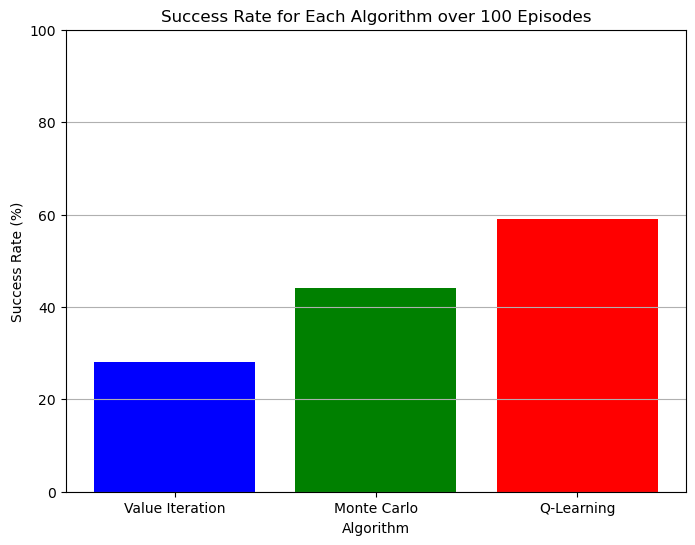

In [49]:
def run_episode_success(env, policy, max_steps=1000):
    s = env.reset()
    steps = 0
    while steps < max_steps:
        a = policy[s]
        if a is None: 
            break
        s, r, done = env.step(s, a)
        steps += 1
        if done:
            break
    return 1 if s == env.goal_state else 0

num_eval_episodes = 100
vi_success = sum(run_episode_success(env_3d, pi_3d) for _ in range(num_eval_episodes))
vi_rate = vi_success / num_eval_episodes * 100
mc_success = sum(run_episode_success(env_3d, pi_mc) for _ in range(num_eval_episodes))
mc_rate = mc_success / num_eval_episodes * 100
ql_success = sum(run_episode_success(env_3d, pi_q) for _ in range(num_eval_episodes))
ql_rate = ql_success / num_eval_episodes * 100
print("Success Rates over {} Evaluation Episodes:".format(num_eval_episodes))
print(f"Value Iteration: {vi_rate:.1f}%")
print(f"Monte Carlo: {mc_rate:.1f}%")
print(f"Q-Learning: {ql_rate:.1f}%")
plt.figure(figsize=(8, 6))
algorithms = ["Value Iteration", "Monte Carlo", "Q-Learning"]
rates = [vi_rate, mc_rate, ql_rate]
plt.bar(algorithms, rates, color=['blue', 'green', 'red'])
plt.xlabel("Algorithm")
plt.ylabel("Success Rate (%)")
plt.title("Success Rate for Each Algorithm over {} Episodes".format(num_eval_episodes))
plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()
